# Q3: CNN for image classification

In this assignment, you'll be coding up a convolutional neural network from scratch to classify images using PyTorch.  

### Instructions
- Install PyTorch following the instructions [here](https://pytorch.org/).
- Install the [`torchinfo` package](https://github.com/TylerYep/torchinfo) to visualize the network architecture and the number of parameters. The maximum number of parameters you are allowed to use for your network is **100,000**. Those who violate this rule will be scored 0 points!!!
- You are required to complete the functions defined in the code blocks following each question. Fill out sections of the code marked `"YOUR CODE HERE"`.
- You're free to add any number of methods within each class.
- You may also add any number of additional code blocks that you deem necessary.

## Data Preparation

In [1]:
# Importing the libraries
import os
import torch
import torchvision
from torchvision.utils import make_grid

import numpy as np

/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In this assignment, we will use the EMNIST dataset. The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.

There are six different splits provided in this datase: byclass, bymerge, balanced, letters, digits and mnist. Here, we will choose 'balanced' split.

Further information on the dataset contents and conversion process can be found in the paper available at https://arxiv.org/abs/1702.05373v1.



### Data

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.  


EMNIST is included in the `torchvision` library.

In [2]:
from torchvision.datasets import EMNIST
from torchvision.transforms import Compose, ToTensor, Normalize

In [3]:
# Transform to normalize the data and convert to a tensor
transform = Compose([ToTensor(),
    Normalize((0.5,), (0.5,))
    ])

# Download the data
dataset = EMNIST('MNIST_data/', download = True, train = True, split = 'balanced', transform = transform)

**NOTE:** You may add more operations to `Compose` if you're performing data augmentation.

## Data Exploration

Let's take a look at the classes in our dataset.

In [4]:
print(dataset.classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


In [5]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: {} ({})'.format(dataset.classes[label], label))
    plt.imshow(img.squeeze(), cmap='Greys_r')
    plt.axis(False)

Label: h (42)


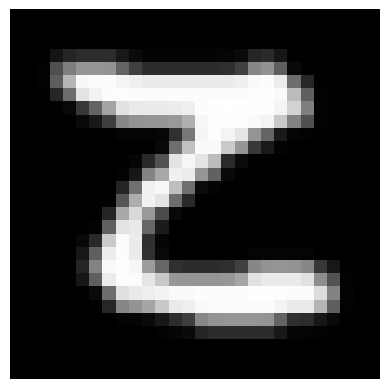

In [6]:
show_example(*dataset[20])

Label: A (10)


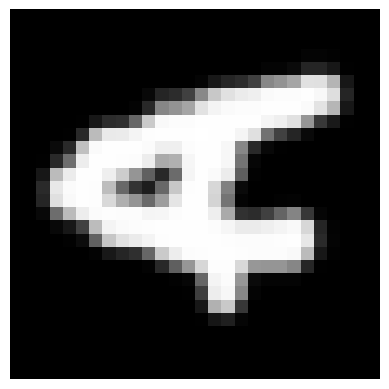

In [7]:
show_example(*dataset[20000])

## Question 1 (2 points)

## Creating Training and Validation Datasets

The `split_indices` function takes in the size of the entire dataset, `n`, the fraction of data to be used as validation set, `val_frac`, and the random seed and returns the indices of the data points to be added to the validation dataset.  

**Choose a suitable fraction for your validation set and experiment with the seed. Remember that the better your validation set, the higher the chances that your model would do well on the test set.**

In [8]:
def split_indices(n, val_frac, seed):
    # Determine the size of the validation set
    n_val = int(val_frac * n)
    np.random.seed(seed)
    # Create random permutation between 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [9]:
######################
#   YOUR CODE HERE   #
######################
val_frac = 0.5 ## Set the fraction for the validation set
rand_seed = 42 ## Set the random seed

train_indices, val_indices = split_indices(len(dataset), val_frac, rand_seed)
print("#samples in training set: {}".format(len(train_indices)))
print("#samples in validation set: {}".format(len(val_indices)))

#samples in training set: 56400
#samples in validation set: 56400


Next, we make use of the built-in dataloaders in PyTorch to create iterables of our our training and validation sets. This helps in avoiding fitting the whole dataset into memory and only loads a batch of the data that we can decide.

**Set the `batch_size` depending on the hardware resource (GPU/CPU RAM) you are using for the assignment.**

In [3]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [11]:
######################
#   YOUR CODE HERE   #
######################
batch_size = 8 ## Set the batch size

In [12]:
# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                     batch_size,
                     sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset,
                   batch_size,
                   sampler=val_sampler)

Plot images in a sample batch of data.

In [13]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, 8).permute(1, 2, 0), cmap='Greys_r')
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


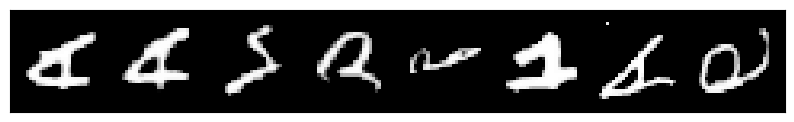

In [14]:
show_batch(train_dl)

## Question 2 (10 points)

## Building the Model

**Create your model by defining the network architecture in the `ImageClassifierNet` class.**  
**NOTE:** The number of parameters in your network must be $\leq$ 100,000.

In [15]:
! pip install torchinfo

In [4]:
# Import the libraries
import torch.nn as nn
import torch.nn.functional as F

from torchinfo import summary
from tqdm import tqdm

In [5]:
class ImageClassifierNet(nn.Module):
    def __init__(self, n_channels=1, dropout=0.5):
        super(ImageClassifierNet, self).__init__()
        ######################
        #   YOUR CODE HERE   #
        ######################
        self.conv1 = nn.Conv2d(n_channels, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size = 2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size = 2)

        self.conv3 = nn.Conv2d(32, 48, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(48)
        self.pool3 = nn.MaxPool2d(kernel_size = 2)

        self.fc1 = nn.Linear(48 * 3 * 3, 128)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(64, 47)


    def forward(self, X):
        ######################
        #   YOUR CODE HERE   #
        ######################
        x = F.relu(self.pool1(self.bn1(self.conv1(X))))
        x = F.relu(self.pool2(self.bn2(self.conv2(x))))
        x = F.relu(self.pool3(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout2(self.fc2(self.dropout1(F.relu(self.fc1(x)))))
        return self.fc3(F.relu(x))


In [18]:
model = ImageClassifierNet()

The following code block prints your network architecture. It also shows the total number of parameters in your network (see `Total params`).  

**NOTE: The total number of parameters in your model should be <= 100,000.**

In [19]:
summary(model, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifierNet                       [8, 47]                   --
├─Conv2d: 1-1                            [8, 16, 28, 28]           160
├─BatchNorm2d: 1-2                       [8, 16, 28, 28]           32
├─MaxPool2d: 1-3                         [8, 16, 14, 14]           --
├─Conv2d: 1-4                            [8, 32, 14, 14]           4,640
├─BatchNorm2d: 1-5                       [8, 32, 14, 14]           64
├─MaxPool2d: 1-6                         [8, 32, 7, 7]             --
├─Conv2d: 1-7                            [8, 48, 7, 7]             13,872
├─BatchNorm2d: 1-8                       [8, 48, 7, 7]             96
├─MaxPool2d: 1-9                         [8, 48, 3, 3]             --
├─Linear: 1-10                           [8, 128]                  55,424
├─Dropout: 1-11                          [8, 128]                  --
├─Linear: 1-12                           [8, 64]                   8,256


## Enable training on a GPU

**NOTE:** This section is necessary if you're training your model on a GPU.

In [6]:
def get_default_device():
    """Use GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [21]:
device = get_default_device()

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

to_device(model, device)

ImageClassifierNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=432, out_features=128, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linea

## Question 3 (10 points)

## Train the model

**Complete the `train_model` function to train your model on a dataset. Tune your network architecture and hyperparameters on the validation set.**

In [22]:
def train_model(n_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr):
    """
    Trains the model on a dataset.

    Args:
        n_epochs: number of epochs
        model: ImageClassifierNet object
        train_dl: training dataloader
        val_dl: validation dataloader
        loss_fn: the loss function
        opt_fn: the optimizer
        lr: learning rate

    Returns:
        The trained model.
        A tuple of (model, train_losses, val_losses, train_accuracies, val_accuracies)
    """
    # Record these values the end of each epoch
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    ######################
    #   YOUR CODE HERE   #
    ######################
    optimizer = opt_fn(model.parameters(), lr=lr)
    for epoch in range(n_epochs):
        model.train()

        epoch_train_loss = 0
        correct_train = 0
        total_train = 0

        for img, label in tqdm(train_dl, desc=f"Training process in epoch {epoch}"):
            output = model(img)
            loss = loss_fn(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            _, predicted = torch.max(output, 1)
            correct_train += (predicted == label).sum().item()
            total_train += label.size(0)

        train_loss = epoch_train_loss / len(train_dl)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()

        epoch_val_loss = 0
        correct_val = 0
        total_val = 0

        if len(val_dl) == 0:
            print(f"Epoch {epoch+1}/{n_epochs}:")
            print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
            continue
        with torch.no_grad():
            for img, label in tqdm(val_dl, desc=f"Testing process in epoch {epoch}"):

                output = model(img)
                loss = loss_fn(output, label)

                epoch_val_loss += loss.item()
                _, predicted = torch.max(output, 1)
                correct_val += (predicted == label).sum().item()
                total_val += label.size(0)

        val_loss = epoch_val_loss / len(val_dl)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{n_epochs}:")
        print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")



    return model, train_losses, val_losses, train_accuracies, val_accuracies

**Set the maximum number of training epochs, the loss function, the optimizer, and the learning rate.**

In [23]:
######################
#   YOUR CODE HERE   #
######################
num_epochs = 30  # Max number of training epochs
loss_fn = torch.nn.CrossEntropyLoss() # Define the loss function
opt_fn = torch.optim.Adam # Select an optimizer
lr = 0.001 # Set the learning rate

In [24]:
history = train_model(num_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr)
model, train_losses, val_losses, train_accuracies, val_accuracies = history

Testing process in epoch 0: 100%|██████████████████████████████████████████████████████████████████████████| 7050/7050 [00:20<00:00, 349.56it/s]


Epoch 1/30:
  Train Loss: 2.1261, Train Accuracy: 0.3491
  Val Loss: 0.8328, Val Accuracy: 0.7359


Testing process in epoch 1: 100%|██████████████████████████████████████████████████████████████████████████| 7050/7050 [00:20<00:00, 349.76it/s]


Epoch 2/30:
  Train Loss: 1.4038, Train Accuracy: 0.5322
  Val Loss: 0.6617, Val Accuracy: 0.7912


Testing process in epoch 2: 100%|██████████████████████████████████████████████████████████████████████████| 7050/7050 [00:19<00:00, 360.56it/s]


Epoch 3/30:
  Train Loss: 1.1523, Train Accuracy: 0.6135
  Val Loss: 0.5647, Val Accuracy: 0.7958


Testing process in epoch 3: 100%|██████████████████████████████████████████████████████████████████████████| 7050/7050 [00:20<00:00, 348.16it/s]


Epoch 4/30:
  Train Loss: 1.0435, Train Accuracy: 0.6523
  Val Loss: 0.5311, Val Accuracy: 0.8226


Testing process in epoch 4: 100%|██████████████████████████████████████████████████████████████████████████| 7050/7050 [00:19<00:00, 359.70it/s]


Epoch 5/30:
  Train Loss: 0.9804, Train Accuracy: 0.6711
  Val Loss: 0.4988, Val Accuracy: 0.8291


Testing process in epoch 5: 100%|██████████████████████████████████████████████████████████████████████████| 7050/7050 [00:19<00:00, 363.83it/s]


Epoch 6/30:
  Train Loss: 0.9248, Train Accuracy: 0.6918
  Val Loss: 0.4956, Val Accuracy: 0.8237


Testing process in epoch 6: 100%|██████████████████████████████████████████████████████████████████████████| 7050/7050 [00:19<00:00, 359.47it/s]


Epoch 7/30:
  Train Loss: 0.8769, Train Accuracy: 0.7044
  Val Loss: 0.5040, Val Accuracy: 0.8237


Testing process in epoch 7: 100%|██████████████████████████████████████████████████████████████████████████| 7050/7050 [00:20<00:00, 347.17it/s]


Epoch 8/30:
  Train Loss: 0.8358, Train Accuracy: 0.7164
  Val Loss: 0.4669, Val Accuracy: 0.8387


Testing process in epoch 8: 100%|██████████████████████████████████████████████████████████████████████████| 7050/7050 [00:19<00:00, 362.55it/s]


Epoch 9/30:
  Train Loss: 0.8133, Train Accuracy: 0.7284
  Val Loss: 0.4579, Val Accuracy: 0.8462


Testing process in epoch 9: 100%|██████████████████████████████████████████████████████████████████████████| 7050/7050 [00:19<00:00, 360.19it/s]


Epoch 10/30:
  Train Loss: 0.7858, Train Accuracy: 0.7356
  Val Loss: 0.4604, Val Accuracy: 0.8438


Testing process in epoch 10: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [00:19<00:00, 358.14it/s]


Epoch 11/30:
  Train Loss: 0.7641, Train Accuracy: 0.7438
  Val Loss: 0.4676, Val Accuracy: 0.8462


Testing process in epoch 11: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [00:19<00:00, 360.47it/s]


Epoch 12/30:
  Train Loss: 0.7499, Train Accuracy: 0.7491
  Val Loss: 0.4526, Val Accuracy: 0.8505


Testing process in epoch 12: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [00:19<00:00, 366.87it/s]


Epoch 13/30:
  Train Loss: 0.7318, Train Accuracy: 0.7556
  Val Loss: 0.4686, Val Accuracy: 0.8408


Testing process in epoch 13: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [00:19<00:00, 360.27it/s]


Epoch 14/30:
  Train Loss: 0.7355, Train Accuracy: 0.7514
  Val Loss: 0.4484, Val Accuracy: 0.8507


Testing process in epoch 14: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [00:20<00:00, 349.98it/s]


Epoch 15/30:
  Train Loss: 0.7148, Train Accuracy: 0.7594
  Val Loss: 0.4502, Val Accuracy: 0.8481


Testing process in epoch 15: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [00:19<00:00, 357.72it/s]


Epoch 16/30:
  Train Loss: 0.7058, Train Accuracy: 0.7610
  Val Loss: 0.4664, Val Accuracy: 0.8482


Testing process in epoch 16: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [00:19<00:00, 359.70it/s]


Epoch 17/30:
  Train Loss: 0.7040, Train Accuracy: 0.7612
  Val Loss: 0.4543, Val Accuracy: 0.8534


Testing process in epoch 17: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [00:19<00:00, 356.05it/s]


Epoch 18/30:
  Train Loss: 0.6996, Train Accuracy: 0.7640
  Val Loss: 0.4730, Val Accuracy: 0.8456


Testing process in epoch 18: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [00:19<00:00, 356.24it/s]


Epoch 19/30:
  Train Loss: 0.6878, Train Accuracy: 0.7680
  Val Loss: 0.4632, Val Accuracy: 0.8499


Testing process in epoch 19: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [00:22<00:00, 309.88it/s]


Epoch 20/30:
  Train Loss: 0.6761, Train Accuracy: 0.7697
  Val Loss: 0.4545, Val Accuracy: 0.8522


Testing process in epoch 20: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [00:25<00:00, 276.05it/s]


Epoch 21/30:
  Train Loss: 0.6724, Train Accuracy: 0.7730
  Val Loss: 0.4636, Val Accuracy: 0.8495


Testing process in epoch 21: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [00:20<00:00, 349.18it/s]


Epoch 22/30:
  Train Loss: 0.6720, Train Accuracy: 0.7737
  Val Loss: 0.4702, Val Accuracy: 0.8489


Testing process in epoch 22: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [00:19<00:00, 361.95it/s]


Epoch 23/30:
  Train Loss: 0.6639, Train Accuracy: 0.7726
  Val Loss: 0.4587, Val Accuracy: 0.8527


Testing process in epoch 23: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [00:19<00:00, 353.55it/s]


Epoch 24/30:
  Train Loss: 0.6550, Train Accuracy: 0.7765
  Val Loss: 0.4658, Val Accuracy: 0.8466


Testing process in epoch 24: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [00:19<00:00, 361.60it/s]


Epoch 25/30:
  Train Loss: 0.6510, Train Accuracy: 0.7785
  Val Loss: 0.4516, Val Accuracy: 0.8563


Testing process in epoch 25: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [00:19<00:00, 359.44it/s]


Epoch 26/30:
  Train Loss: 0.6423, Train Accuracy: 0.7777
  Val Loss: 0.4726, Val Accuracy: 0.8565


Testing process in epoch 26: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [00:19<00:00, 358.86it/s]


Epoch 27/30:
  Train Loss: 0.6437, Train Accuracy: 0.7807
  Val Loss: 0.4648, Val Accuracy: 0.8542


Testing process in epoch 27: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [00:19<00:00, 360.71it/s]


Epoch 28/30:
  Train Loss: 0.6337, Train Accuracy: 0.7826
  Val Loss: 0.4663, Val Accuracy: 0.8459


Testing process in epoch 28: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [00:19<00:00, 363.85it/s]


Epoch 29/30:
  Train Loss: 0.6339, Train Accuracy: 0.7844
  Val Loss: 0.4799, Val Accuracy: 0.8537


Testing process in epoch 29: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [00:24<00:00, 287.68it/s]

Epoch 30/30:
  Train Loss: 0.6257, Train Accuracy: 0.7857
  Val Loss: 0.4747, Val Accuracy: 0.8539


## Plot loss and accuracy

In [25]:
def plot_accuracy(train_accuracies, val_accuracies):
    """Plot accuracies"""
    plt.plot(train_accuracies, "-x")
    plt.plot(val_accuracies, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Training", "Validation"])
    plt.title("Accuracy vs. No. of epochs")

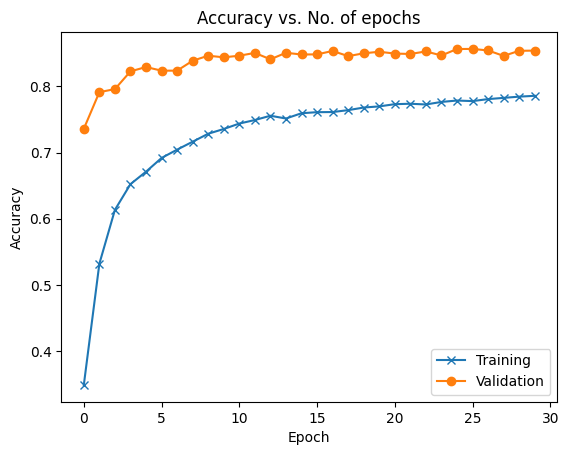

In [26]:
plot_accuracy(train_accuracies, val_accuracies)

In [27]:
def plot_losses(train_losses, val_losses):
    """Plot losses"""
    plt.plot(train_losses, "-x")
    plt.plot(val_losses, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of Epochs")

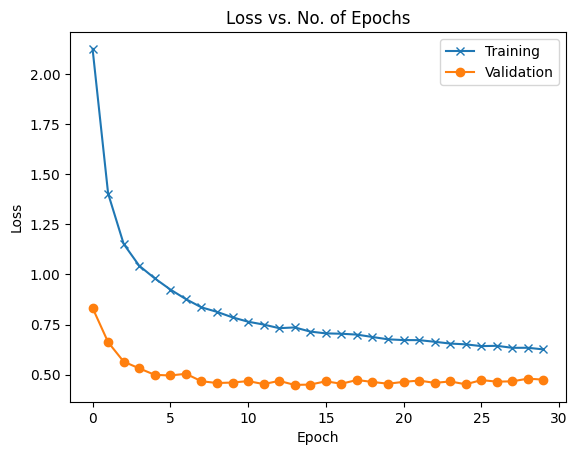

In [28]:
plot_losses(train_losses, val_losses)

## Train a model on the entire dataset

In [29]:
indices, _ = split_indices(len(dataset), 0, rand_seed)

sampler = SubsetRandomSampler(indices)
dl = DataLoader(dataset, batch_size, sampler=sampler)
dl = DeviceDataLoader(dl, device)

**Set the maximum number of training epochs and the learning rate for finetuning your model.**

In [30]:
######################
#   YOUR CODE HERE   #
######################
num_epochs = 20 # Max number of training epochs
lr = 0.001 # Set the learning rate

In [31]:
history = train_model(num_epochs, model, dl, [], loss_fn, opt_fn, lr)
model = history[0]

Training process in epoch 0: 100%|███████████████████████████████████████████████████████████████████████| 14100/14100 [01:30<00:00, 155.73it/s]


Epoch 1/20:
  Train Loss: 0.7172, Train Accuracy: 0.7711


Training process in epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 14100/14100 [01:28<00:00, 159.42it/s]


Epoch 2/20:
  Train Loss: 0.6911, Train Accuracy: 0.7747


Training process in epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 14100/14100 [01:37<00:00, 145.22it/s]


Epoch 3/20:
  Train Loss: 0.6775, Train Accuracy: 0.7783


Training process in epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 14100/14100 [01:39<00:00, 141.21it/s]


Epoch 4/20:
  Train Loss: 0.6704, Train Accuracy: 0.7817


Training process in epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 14100/14100 [01:38<00:00, 143.41it/s]


Epoch 5/20:
  Train Loss: 0.6654, Train Accuracy: 0.7822


Training process in epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 14100/14100 [01:29<00:00, 156.90it/s]


Epoch 6/20:
  Train Loss: 0.6625, Train Accuracy: 0.7835


Training process in epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 14100/14100 [01:39<00:00, 141.09it/s]


Epoch 7/20:
  Train Loss: 0.6555, Train Accuracy: 0.7842


Training process in epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 14100/14100 [01:33<00:00, 150.12it/s]


Epoch 8/20:
  Train Loss: 0.6454, Train Accuracy: 0.7888


Training process in epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 14100/14100 [01:34<00:00, 149.12it/s]


Epoch 9/20:
  Train Loss: 0.6479, Train Accuracy: 0.7883


Training process in epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 14100/14100 [01:36<00:00, 145.56it/s]


Epoch 10/20:
  Train Loss: 0.6429, Train Accuracy: 0.7907


Training process in epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 14100/14100 [01:35<00:00, 148.14it/s]


Epoch 11/20:
  Train Loss: 0.6364, Train Accuracy: 0.7902


Training process in epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 14100/14100 [01:53<00:00, 123.84it/s]


Epoch 12/20:
  Train Loss: 0.6386, Train Accuracy: 0.7912


Training process in epoch 12: 100%|██████████████████████████████████████████████████████████████████████| 14100/14100 [01:44<00:00, 134.80it/s]


Epoch 13/20:
  Train Loss: 0.6361, Train Accuracy: 0.7914


Training process in epoch 13: 100%|██████████████████████████████████████████████████████████████████████| 14100/14100 [01:36<00:00, 146.18it/s]


Epoch 14/20:
  Train Loss: 0.6327, Train Accuracy: 0.7925


Training process in epoch 14: 100%|██████████████████████████████████████████████████████████████████████| 14100/14100 [01:44<00:00, 135.31it/s]


Epoch 15/20:
  Train Loss: 0.6312, Train Accuracy: 0.7923


Training process in epoch 15: 100%|██████████████████████████████████████████████████████████████████████| 14100/14100 [01:48<00:00, 130.48it/s]


Epoch 16/20:
  Train Loss: 0.6254, Train Accuracy: 0.7941


Training process in epoch 16: 100%|██████████████████████████████████████████████████████████████████████| 14100/14100 [01:40<00:00, 141.00it/s]


Epoch 17/20:
  Train Loss: 0.6252, Train Accuracy: 0.7940


Training process in epoch 17: 100%|██████████████████████████████████████████████████████████████████████| 14100/14100 [01:38<00:00, 142.59it/s]


Epoch 18/20:
  Train Loss: 0.6290, Train Accuracy: 0.7940


Training process in epoch 18: 100%|██████████████████████████████████████████████████████████████████████| 14100/14100 [01:30<00:00, 155.75it/s]


Epoch 19/20:
  Train Loss: 0.6294, Train Accuracy: 0.7930


Training process in epoch 19: 100%|██████████████████████████████████████████████████████████████████████| 14100/14100 [01:29<00:00, 157.13it/s]

Epoch 20/20:
  Train Loss: 0.6261, Train Accuracy: 0.7942


## Check Predictions

In [32]:
def view_prediction(img, label, probs, classes):
    """
    Visualize predictions.
    """
    probs = probs.cpu().numpy().squeeze()
    fig, (ax1, ax2) = plt.subplots(figsize=(8,15), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).cpu().numpy().squeeze(), cmap='Greys_r')
    ax1.axis('off')
    ax1.set_title('Actual: {}'.format(classes[label]))
    ax2.barh(np.arange(47), probs)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(47))
    ax2.set_yticklabels(classes, size='small');
    ax2.set_title('Predicted: probabilities')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

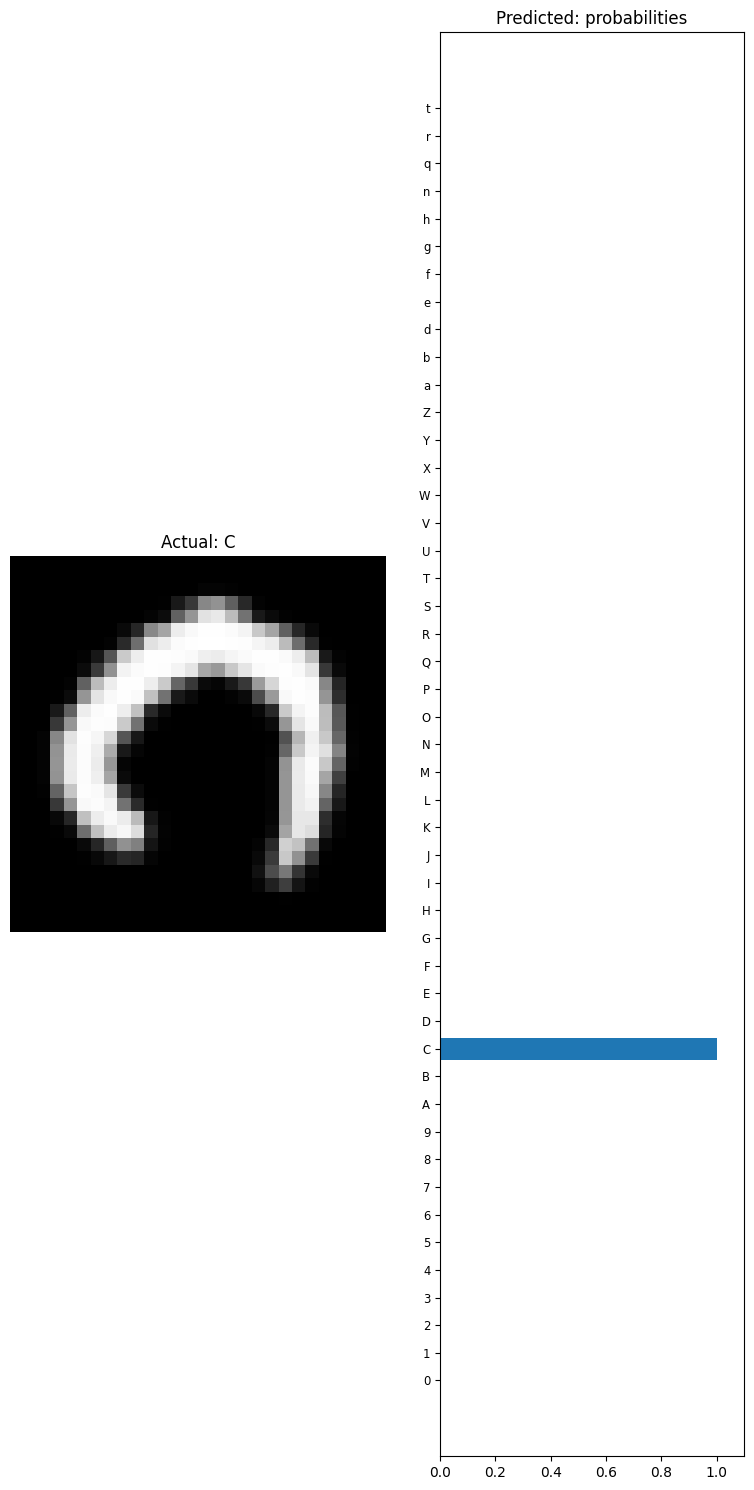

In [33]:
# Calculate the class probabilites (log softmax) for img
images = iter(dl)
for imgs, labels in images:
    with torch.no_grad():
        model.eval()
        # Calculate the class probabilites (log softmax) for img
        probs = torch.nn.functional.softmax(model(imgs[0].unsqueeze(0)), dim=1)
        # Plot the image and probabilites
        view_prediction(imgs[0], labels[0], probs, dataset.classes)
    break

## Save the model

In [35]:
# Very important
torch.save(model, 'output_model/basic_model.pth')

## Question 4 (8 points)

## Compute accuracy on the test set

In [13]:
test_dataset = EMNIST('MNIST_data/', download = True, train = False, split = 'balanced', transform = transform)

In [15]:
test_dl = DataLoader(test_dataset, batch_size)
test_dl = DeviceDataLoader(test_dl, device)

In [17]:
def evaluate(model, test_dl):
    """
    Evaluates your model on the test data.

    Args:
        model: ImageClassifierNet object
        test_dl: test dataloader

    Returns:
        Test accuracy.
    """
    ######################
    #   YOUR CODE HERE   #
    ######################
    model.eval()

    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for img, label in test_dl:
            output = model(img)

            _, predicted = torch.max(output, 1)
            correct_val += (predicted == label).sum().item()
            total_val += label.size(0)

    return correct_val / total_val



In [39]:
print("Test Accuracy = {:.4f}".format(evaluate(model, test_dl)))

Test Accuracy = 0.8674


## Tips to increase the test accuracy

- **Data augmentation:** Diversifies your training set and leads to better generalization
    - Flipping
    - Rotation
    - Shifting
    - Cropping
    - Adding noise
    - Blurring
    
- **Regularization:** Reduces overfitting on the training set
    - Early stopping
    - Dropout
    - $l_2$ regularization
    - Batch normalization

- **Hyperparameter tuning:**
    - Weight initialization
    - Learning rate
    - Activation functions
    - Optimizers

### Add data augmentation
In this section, I will add preprocessing to the image part. The selected image enhancement operations are as follows:
* Flipping (Horizon)
* Rotation (random rotate +- 10)
* Random Crop (from 90% to 100%)
* Add Gaussian noice

**Output:** A model parameter. I will campare with other methods in the last part


In [40]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(28, scale=(0.9, 1.0)),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = EMNIST('MNIST_data/', download = False, train = True, split = 'balanced', transform = transform)

val_frac = 0.5
rand_seed = 42

train_indices, val_indices = split_indices(len(dataset), val_frac, rand_seed)

batch_size = 8

train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                     batch_size,
                     sampler=train_sampler)

val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset,
                   batch_size,
                   sampler=val_sampler)

device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

model = ImageClassifierNet()
to_device(model, device)

num_epochs = 30
loss_fn = torch.nn.CrossEntropyLoss()
opt_fn = torch.optim.Adam
lr = 0.001

history = train_model(num_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr)
model = history[0]

torch.save(model, 'output_model/data_augment_model.pth')


Testing process in epoch 0: 100%|██████████████████████████████████████████████████████████████████████████| 7050/7050 [00:58<00:00, 119.87it/s]


Epoch 1/30:
  Train Loss: 2.7386, Train Accuracy: 0.1846
  Val Loss: 1.6915, Val Accuracy: 0.4698


Testing process in epoch 1: 100%|██████████████████████████████████████████████████████████████████████████| 7050/7050 [00:56<00:00, 124.03it/s]


Epoch 2/30:
  Train Loss: 2.0095, Train Accuracy: 0.3483
  Val Loss: 1.2994, Val Accuracy: 0.5715


Testing process in epoch 2: 100%|██████████████████████████████████████████████████████████████████████████| 7050/7050 [00:57<00:00, 123.36it/s]


Epoch 3/30:
  Train Loss: 1.7645, Train Accuracy: 0.4126
  Val Loss: 1.1359, Val Accuracy: 0.6246


Testing process in epoch 3: 100%|██████████████████████████████████████████████████████████████████████████| 7050/7050 [00:55<00:00, 126.98it/s]


Epoch 4/30:
  Train Loss: 1.5970, Train Accuracy: 0.4701
  Val Loss: 1.0324, Val Accuracy: 0.6475


Testing process in epoch 4: 100%|██████████████████████████████████████████████████████████████████████████| 7050/7050 [00:55<00:00, 127.46it/s]


Epoch 5/30:
  Train Loss: 1.5173, Train Accuracy: 0.4966
  Val Loss: 0.9901, Val Accuracy: 0.6602


Testing process in epoch 5: 100%|██████████████████████████████████████████████████████████████████████████| 7050/7050 [00:57<00:00, 123.64it/s]


Epoch 6/30:
  Train Loss: 1.4603, Train Accuracy: 0.5144
  Val Loss: 0.9754, Val Accuracy: 0.6777


Testing process in epoch 6: 100%|██████████████████████████████████████████████████████████████████████████| 7050/7050 [00:56<00:00, 124.50it/s]


Epoch 7/30:
  Train Loss: 1.4115, Train Accuracy: 0.5304
  Val Loss: 0.9233, Val Accuracy: 0.6810


Testing process in epoch 7: 100%|██████████████████████████████████████████████████████████████████████████| 7050/7050 [00:55<00:00, 127.19it/s]


Epoch 8/30:
  Train Loss: 1.3682, Train Accuracy: 0.5496
  Val Loss: 0.9005, Val Accuracy: 0.6806


Testing process in epoch 8: 100%|██████████████████████████████████████████████████████████████████████████| 7050/7050 [00:56<00:00, 124.17it/s]


Epoch 9/30:
  Train Loss: 1.3337, Train Accuracy: 0.5607
  Val Loss: 0.8745, Val Accuracy: 0.6990


Testing process in epoch 9: 100%|██████████████████████████████████████████████████████████████████████████| 7050/7050 [01:02<00:00, 112.86it/s]


Epoch 10/30:
  Train Loss: 1.3124, Train Accuracy: 0.5653
  Val Loss: 0.8432, Val Accuracy: 0.7092


Testing process in epoch 10: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [01:02<00:00, 113.11it/s]


Epoch 11/30:
  Train Loss: 1.2904, Train Accuracy: 0.5763
  Val Loss: 0.8338, Val Accuracy: 0.7155


Testing process in epoch 11: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [00:57<00:00, 123.48it/s]


Epoch 12/30:
  Train Loss: 1.2739, Train Accuracy: 0.5806
  Val Loss: 0.8393, Val Accuracy: 0.7190


Testing process in epoch 12: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [00:59<00:00, 119.38it/s]


Epoch 13/30:
  Train Loss: 1.2554, Train Accuracy: 0.5900
  Val Loss: 0.8253, Val Accuracy: 0.7145


Testing process in epoch 13: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [00:54<00:00, 128.29it/s]


Epoch 14/30:
  Train Loss: 1.2466, Train Accuracy: 0.5939
  Val Loss: 0.8090, Val Accuracy: 0.7207


Testing process in epoch 14: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [00:56<00:00, 125.58it/s]


Epoch 15/30:
  Train Loss: 1.2259, Train Accuracy: 0.5996
  Val Loss: 0.8139, Val Accuracy: 0.7150


Testing process in epoch 15: 100%|██████████████████████████████████████████████████████████████████████████| 7050/7050 [01:11<00:00, 98.18it/s]


Epoch 16/30:
  Train Loss: 1.2101, Train Accuracy: 0.6041
  Val Loss: 0.7893, Val Accuracy: 0.7283


Testing process in epoch 16: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [01:08<00:00, 103.50it/s]


Epoch 17/30:
  Train Loss: 1.2081, Train Accuracy: 0.6062
  Val Loss: 0.7862, Val Accuracy: 0.7346


Testing process in epoch 17: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [01:02<00:00, 112.82it/s]


Epoch 18/30:
  Train Loss: 1.2049, Train Accuracy: 0.6119
  Val Loss: 0.8028, Val Accuracy: 0.7293


Testing process in epoch 18: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [00:55<00:00, 127.04it/s]


Epoch 19/30:
  Train Loss: 1.1912, Train Accuracy: 0.6128
  Val Loss: 0.7927, Val Accuracy: 0.7357


Testing process in epoch 19: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [00:58<00:00, 119.80it/s]


Epoch 20/30:
  Train Loss: 1.1924, Train Accuracy: 0.6129
  Val Loss: 0.7597, Val Accuracy: 0.7459


Testing process in epoch 20: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [00:56<00:00, 125.62it/s]


Epoch 21/30:
  Train Loss: 1.1729, Train Accuracy: 0.6210
  Val Loss: 0.7783, Val Accuracy: 0.7346


Testing process in epoch 21: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [00:55<00:00, 126.66it/s]


Epoch 22/30:
  Train Loss: 1.1664, Train Accuracy: 0.6212
  Val Loss: 0.7513, Val Accuracy: 0.7382


Testing process in epoch 22: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [00:56<00:00, 124.72it/s]


Epoch 23/30:
  Train Loss: 1.1582, Train Accuracy: 0.6221
  Val Loss: 0.7572, Val Accuracy: 0.7444


Testing process in epoch 23: 100%|██████████████████████████████████████████████████████████████████████████| 7050/7050 [01:28<00:00, 79.52it/s]


Epoch 24/30:
  Train Loss: 1.1559, Train Accuracy: 0.6250
  Val Loss: 0.7530, Val Accuracy: 0.7434


Testing process in epoch 24: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [00:58<00:00, 120.84it/s]


Epoch 25/30:
  Train Loss: 1.1559, Train Accuracy: 0.6259
  Val Loss: 0.7619, Val Accuracy: 0.7461


Testing process in epoch 25: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [00:56<00:00, 124.22it/s]


Epoch 26/30:
  Train Loss: 1.1567, Train Accuracy: 0.6303
  Val Loss: 0.7551, Val Accuracy: 0.7464


Testing process in epoch 26: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [01:00<00:00, 116.47it/s]


Epoch 27/30:
  Train Loss: 1.1414, Train Accuracy: 0.6289
  Val Loss: 0.7684, Val Accuracy: 0.7393


Testing process in epoch 27: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [01:01<00:00, 114.69it/s]


Epoch 28/30:
  Train Loss: 1.1452, Train Accuracy: 0.6304
  Val Loss: 0.7341, Val Accuracy: 0.7512


Testing process in epoch 28: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [01:07<00:00, 104.47it/s]


Epoch 29/30:
  Train Loss: 1.1331, Train Accuracy: 0.6331
  Val Loss: 0.7510, Val Accuracy: 0.7469


Testing process in epoch 29: 100%|█████████████████████████████████████████████████████████████████████████| 7050/7050 [01:01<00:00, 115.50it/s]

Epoch 30/30:
  Train Loss: 1.1340, Train Accuracy: 0.6359
  Val Loss: 0.7765, Val Accuracy: 0.7340


## Fine tune parameter

In [ ]:
transform = Compose([ToTensor(),
    Normalize((0.5,), (0.5,))
    ])

dataset = EMNIST('MNIST_data/', download = False, train = True, split = 'balanced', transform = transform)

val_frac = 0.5
rand_seed = 42

train_indices, val_indices = split_indices(len(dataset), val_frac, rand_seed)

batch_size = 8

# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                     batch_size,
                     sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset,
                   batch_size,
                   sampler=val_sampler)

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

num_epochses = [30, 50, 70]
lrs = [0.005, 0.001, 0.0005]

for num_epochs in num_epochses:
    for lr in lrs:
        print(f"\n=== Use lr:{lr} with epoch:{num_epochs} ===")        
        model = ImageClassifierNet()
        to_device(model, device)
        
        loss_fn = torch.nn.CrossEntropyLoss()
        opt_fn = torch.optim.Adam
        
        history = train_model(num_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr)
        model = history[0]
    
        torch.save(model, f'output_model/{num_epochs}_{lr}_model.pth')


In [18]:
model_dir = "output_model"

model_files = [f for f in os.listdir(model_dir) if f.endswith('.pth')]
model_files.sort()

if not model_files:
    print("Without find any model file!")
else:
    print(f"Find {len(model_files)} number of model files, Testing...")

    for model_file in model_files:
        model_path = os.path.join(model_dir, model_file)

        try:
            model = torch.load(model_path)
            device = get_default_device()
            to_device(model, device)
            
            # state_dict = torch.load(model_path)
            # model.load_state_dict(state_dict)
            model.eval()

            accuracy = evaluate(model, test_dl)

            print(f"model: {model_file} - Test accuracy = {accuracy:.4f}")

        except Exception as e:
            print(f"model:  {model_file} error: {str(e)}")

Find 11 number of model files, Testing...
model: 30_0.0005_model.pth - Test accuracy = 0.8644
model: 30_0.001_model.pth - Test accuracy = 0.8506
model: 30_0.005_model.pth - Test accuracy = 0.6796
model: 50_0.0005_model.pth - Test accuracy = 0.8621
model: 50_0.001_model.pth - Test accuracy = 0.8574
model: 50_0.005_model.pth - Test accuracy = 0.5891
model: 70_0.0005_model.pth - Test accuracy = 0.8645
model: 70_0.001_model.pth - Test accuracy = 0.8507
model: 70_0.005_model.pth - Test accuracy = 0.6436
model: basic_model.pth - Test accuracy = 0.8509
model: data_augment_model.pth - Test accuracy = 0.7615


## Experience Result Analysis
Using model parameters previously trained with different hyperparameters and data augmentation strategies, we conducted a brief ablation study to analyze their effects on model performance. The results indicate that a smaller learning rate (0.0005) consistently led to higher test accuracy, achieving around 86% across different epoch settings (30, 50, and 70 epochs). Increasing the learning rate to 0.001 caused a slight decrease in performance, while a learning rate of 0.005 significantly degraded accuracy, highlighting the importance of careful learning rate selection. In contrast, the number of training epochs had a relatively minor impact once the model had sufficiently converged, suggesting that extended training beyond 30 epochs brought limited additional benefits.

Furthermore, we compared the performance of a basic model with a model trained using data augmentation techniques. The basic model achieved a test accuracy of 85.09%, whereas the data-augmented model reached only 76.15%. This decline suggests that the current data augmentation strategy did not effectively enhance the model’s generalization ability and may have introduced additional complexity that hindered performance. Overall, these results emphasize that optimizing the learning rate plays a critical role in improving model accuracy, while adjustments to the number of epochs and simple data augmentation strategies have relatively limited effects.